In [1]:
#calcuration libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
%matplotlib inline

### Material properties

In [2]:
A = 0.818;
B = 3.664E-3;
def cp(T):
    cp = (A + B * (T+273.15));
    return cp
def cp_K(T):
    cp_K = A + B * (T);
    cp_K =  cp_K *1000;##???
    return cp_K

C = 0.157;
D = -7.328E-5;
def Lambda(T):
    Lambda = C + D * (T+273.15);
    return Lambda
def Lambda_K(T):
    Lambda_K = C + D * (T);
    return Lambda_K

E = 5.894E-5;
F = 857.4;
G = -172.2;
def mu(T):
    mu = E * np.exp( F / ( (T+273.15) + G) );
    return mu
def mu_K(T):
    mu_K = E * np.exp( F / ( (T) + G) );
    return mu_K

H = 1045;
I = -0.616;
def rho(T):
    rho = H + I * (T+273.15);
    return rho
def rho_K(T):
    rho_K = H + I * (T);
    return rho_K

def nu(T):
    nu = mu(T)/rho(T);
    return nu
def nu_K(T):
    nu = mu_K(T)/rho_K(T);
    return nu

def Pr(T):
    Pr = ( mu(T) * cp(T) * 1000 ) / Lambda(T);
    return Pr
def Pr_K(T):
    Pr = ( mu_K(T) * cp_K(T)) / Lambda_K(T);
    return Pr

### read measurement data 6-115

In [3]:
# 取り出したい列を（0始まりで）指定する．
filename = './pr50_csv/Daten_19.11.2018_15.34.54.csv'
data = np.array(pd.read_csv(filename, skiprows=0, encoding='shift-jis'))

In [4]:
di=12E-3
da=15E-3
ri = di/2
ra = da/2
disoa = 90E-3
L=2
V=(da**2-di**2)*np.pi/4*L
Ageo_MS = di*np.pi*L #円菅内部の試験部表面積
Ugeo_MS = di*np.pi #円菅内面積
Ageo_quer = di**2*np.pi/4

Tsa = data[:,0] #Temperatur aussen: Ts_aussen / °C
Tsi = data[:,1] #Temperatur innen: Ts innen / °C
Ti = data[:,2] #Fluidtemperatur: T / °C
m_dot_C1 = data[0,3] #Massenstrom: m_dot C1 / kg/h
m_dot_C2 = data[0,4] #Massenstrom: m_dot C2 / kg/h

Re_C1 = data[0,5] #Re C1 / -
Re_C2 = data[0,6] #Re C2 / -

v_C1 = data[0,7] #Geschwindigkeit: v C1 / m/s
v_C2 = data[0,8] #Geschwindigkeit: v C2 / m/s

U_MS = data[0,9] #Spannungsabfall Messstrecke: U_MS / V
I_MS = data[0,10] #Strom Messstrecke: I_MS / A
P_MS = data[0,11] #Leistung Messstrecke: P_MS / W

q = data[0,12] #spzifische Leistung: q / W/m3
P1 = data[0,13] #Druckmessung: P1 / Pa
P2 = data[0,14] #Druckmessung: P2 / Pa
dp = data[0,15] #Differenzdruck: dp / bar
nu_Fluid = data[0,16] #kin. Viscositaet Fluid: nu / m2/s
rho_Fluid = data[0,17] #Dichte Fluid: rho / kg/m3
Lambda_Fluid = data[0,18] #Waermeleitfaehigkeit Fluid: lambda / W/mK
cp_Fluid = data[0,19] #spez. Waermekapazitaet Fluid: cp /J/kgK
Pr_Fluid = data[0,20] #Pr / -
Lambda_Rohr = data[0,21] #Waermeleitfaehigkeit Rohr: lambda / W/mK
Nu_Fluid = data[0,22] #Nu / -

I1 = data[0,23] #Strom I / A
U1 = data[0,24] #Spannung U / V

dp_T1 = data[0,25] #Re_tau / - 関数名とtxtが合っていない？
dp_T2 = data[0,26] #Re_tau_Pet / -　関数名とtxtが合っていない？
dp_T3 = data[0,27] #dp Pet / Pa

#Mittel (U*I) mean P / W
Pm = data[0,28] #Mittel (U*I) mean P / W
TPT100_a = data[:5,29] #PT100 T aussen(5 value)
TPT100_i = data[:5,30] #PT100 T innen(5 value)
TPT100_m = data[:5,31] #PT100 T mittel(5 value)

NuPt100 = data[0,32] #Nu Pt100
NuQm = data[0,33] #Nu Qm

# zeta computation Einlesen
ZRem100 = data[0,34] #zeta Re
Zzeta100 = data[0,35] #zeta
Zqm100 = data[0,36] #zeta qw

TPT100_T5 = data[0,37] #PT100 T5

### conduction equation for inner wall temperatuer 110-115

In [5]:
#Lambda_K = 0.16
DeltaK = 0.065E-3
Lambda_N = 20
Lambda_C = 0.16 #thermal conductivity[W/mK] of capton tape
Lambda_iso = 0.055 #thermal conductivity[W/mK] of glass wool, outer isolation
riso = 0.05 #thickness of isolation????????????

#temperature distribution in pipe(ri << r << ra)
def T1(r,qv,qzu,TN,Ta):
    T1 = (qzu/(2*Lambda_N)*ra**2)*(0.5-0.5*(r/ra)**2+np.log(r/ra)) + Ta - qv/Lambda_N*(ra+DeltaK)*(Lambda_N/Lambda_C*np.log(ra/(ra+DeltaK))+np.log(r/ra))
    return T1

#temperature distribution in capton tape(ra << r << ra+DeltaK)
def T2(r,qv,Ta):
    T2 = - qv/Lambda_C*(ra+DeltaK)*np.log(r/(ra+DeltaK)) + Ta
    return T2

### Definition der Temperaturen und MesspositionenCoeff_lf 148-203

In [6]:
x_pos_TPt100 = [1.970, 2.470, 2.970, 5.500, 0.05]
xTin  = 0.05
xTout = 5.50

x_MS_in = 1.2
x_MS_out = 3.2

In [7]:
#TPT100 = np.zeros([5])#いらない？？？
TPT100 = TPT100_i
Tm_aus = TPT100[3];
Tm = Tm_aus

### iteration to update the temperatuer dependent material properties --> new wall temperature 205-339

In [8]:
for i in range(2):
    Tw = TPT100[2]
    T_iso = Ti[1]
    T_inf = Ti[6]

    #Berechnung der Fluid Stoffwerte
    Pr_w = Pr(Tw)
    Pr_w     = Pr(Tw)
    rho_w    = rho(Tw)
    nu_w     = nu(Tw)
    mu_w     = nu_w * rho_w
    cp_w     = cp(Tw)
    Lambda_w = Lambda(Tw)

    Pr_m     = Pr(Tm)
    rho_m    = rho(Tm)
    nu_m     = nu(Tm)
    mu_m     = nu_m * rho_m
    cp_m     = cp(Tm)
    Lambda_m = Lambda(Tm)
    
    #Korrektur mittel Temperatur
    dqhldT = 1
    zeta_mischer = 32.46

    Thl = (Tw + Tm)*0.5 #!!!!!!!!!!!!!!!!
    qhl = dqhldT * (Thl - T_iso)

    qhlm2 = qhl / (da*np.pi*5.45)

    Re_m = Re_C1;
    Lambda_Pet = (1.8*np.log(Re_m)-1.5)**(-2) #Eq(4.17)??????????
    
    #Specific heat capasity, cp mean
    T_in = TPT100[4] + 273.15
    T_out = TPT100[3] + 273.15

    Ac = 0.818
    Bc = 3.664E-3
    cpm = (Ac*(T_out-T_in)+Bc/2*(T_out**2-T_in**2))/(T_out-T_in)*1000 #Eq(2.108)

    Wmean = Re_m*nu_m/di
    mdot = m_dot_C1/3600
 
    #TPT100[:3].transpose()?????????
    fit = np.polyfit(x_pos_TPt100[:3],TPT100[:3],1)
    print(fit)#?????????
    gradT_PT100 = fit[0]
    
    Q_Pt100 = gradT_PT100*mdot*cpm*L
    qUI = P_MS/Ageo_MS
    dqw2 = (Lambda_Pet*(5.45-2.92)/di + zeta_mischer) * rho_m * Wmean**2/2 * Wmean * Ageo_quer - qhl*(5.45-2.53)/5.45
    
    Qin_out = mdot*cpm*(T_out-T_in)
    dQ = Qin_out-P_MS
    
    #Q=m_dot * cp_m * DT
    gradT = (Qin_out/L) / (mdot * cpm )
    dTm = dqw2/(mdot*cpm)
    SA_Tm = gradT*(x_MS_out-x_pos_TPt100[2])
    
    Tm_aus = TPT100[3] - dTm
    Tm = Tm_aus - SA_Tm
    
    qw = Qin_out/ Ageo_MS
    if(Qin_out>0):
        qvA=qhlm2
        print('qvA=qhlm2')
    else:
        qvA=0
        print('qvA=0')
        
    Pr_w     = Pr(Tw)
    rho_w    = rho(Tw)
    nu_w     = nu(Tw)
    mu_w     = nu_w * rho_w
    cp_w     = cp(Tw)
    Lambda_w = Lambda(Tw)

    Pr_m     = Pr(Tm)
    rho_m    = rho(Tm)
    nu_m     = nu(Tm)
    mu_m     = nu_m * rho_m
    cp_m     = cp(Tm)
    Lambda_m = Lambda(Tm)
    
    #P_spez_m2 = P_MS/A;
    P=Pm
    P=P_MS
    
    #Reynolds number[-]
    Re_m = Re_C1
    Re_w = Re_C2
    
    Re_m = m_dot_C1/3600*4/(nu_m*rho_m*di*np.pi)
    Re_w = m_dot_C1/3600*4/(nu_w*rho_m*di*np.pi)
    
    #Wall temperature calibration
    qVol = Qin_out / V

    Tw = T1(ri,qvA,qVol,TPT100_a[2], TPT100_a[2]);
    Tw_SA = T1(ri,qvA,qVol, TPT100_a[0], TPT100_a[0]);
    Tw_SA2 = T1(ri,qvA,qVol, TPT100_a[1], TPT100_a[1]);

    TPT100[2] = Tw
    TPT100[0] = Tw_SA
    TPT100[1] = Tw_SA2

[  1.421533   109.60405082]
qvA=qhlm2
[  1.421533   109.84483793]
qvA=qhlm2


In [9]:
Nu_QmdotCpDt_w = qw * di / (Lambda_w * (Tw-Tm ))
NuMessung = Nu_QmdotCpDt_w

In [10]:
tau_w = dp*di/(1*4)
w_tau=(tau_w/rho_m)**(1/2) #share velocity
ReTau = w_tau*di/nu_w

cf_M = tau_w/(rho_m*Wmean**2/2) #Friction coefficient Eq(4.8)

In [11]:
#桁数は四捨五入ではなく、「丸め」であることに注意
print('T','{:.4f}'.format(T_in), '{:.4f}'.format(T_out), '{:.4f}'.format(Tw), '{:.4f}'.format(Tm))
print('mdot', '{:.4f}'.format(mdot))
print('qw', '{:.4e}'.format(qw))
print("Re[-]",'{:.4e}'.format(Re_m), '{:.4e}'.format(Re_w), '{:.4f}'.format(ReTau))
print('Pr[-]', '{:.4f}'.format(Pr_m), '{:.4f}'.format(Pr_w))
print('Nu','{:.4f}'.format(NuMessung))
print('cf','{:.4f}'.format(cf_M))

T 361.7502 364.9067 113.8782 91.5150
mdot 0.1341
qw 1.2066e+04
Re[-] 2.8057e+03 4.3861e+03 290.1047
Pr[-] 83.8541 55.4416
Nu 50.3299
cf 0.0087


### Measurement uncertainty Ref. Bertsche2016

In [12]:
#### absolute error
#PT100 [K]
T_e = 0.2
#mass flow rate [kg / s]
mdot_e = 0.20E-3 * mdot
#pressure[Pa]
p_e = 0.35E-3 * dp #dpでいいの???????????
#density [kg / m^3]
rho_e = 0.13
#specific heat capasity [J / kg K]
cp_e = 0.73
#thermal conductivity of fluid [W / m K]
Lambda_e = 1.56E-5

In [13]:
#Uncertainty in each measurement influencing
delta_mdot = (mdot_e / mdot)**2
delta_cp = (cp_e/cp_m)**2 #cpm、cp_mどちら？
delta_Lambda = (Lambda_e/Lambda_m)**2
delta_T = (T_e/(T_in-Tm))**2 + ((T_e * (T_in-Tw)) / ((T_in-Tm)*(Tm-Tw)))**2 + (T_e/(Tm-Tw) )**2#T_outは影響しない？
#Measurement uncertainty for NuMessung
delta_NuMessung = (delta_mdot + delta_cp + delta_Lambda + delta_T)**(1/2) * NuMessung
#Reduction of the uncertainty of the cp calibration is the most effective, in order to reduce the uncertainty of Nu.
print(delta_mdot)
print(delta_cp)#dominating part
print(delta_Lambda)
print(delta_T)
print(delta_NuMessung)

4e-08
0.11484203705085659
1.4338752454641304e-08
0.00014782217880626475
17.06695105341561


In [14]:
#Uncertainty in each measurement influencing
delta_p = (p_e / dp)**2
delta_rho = (rho_e / rho_m)**2
#Measurement uncertainty for cf_M
delta_cf_M = (delta_p + delta_rho + (2*delta_mdot))**(1/2) * cf_M
#Reduction of the uncertainty of the p calibration is the most effective, in order to reduce the uncertainty of cf.
print(delta_p)#dominating part
print(delta_rho)
print(delta_mdot)
print(delta_cf_M)

1.225e-07
2.5111404868590414e-08
4e-08
4.12789658362301e-06


In [15]:
# データフレームを作成
df = pd.DataFrame([
    [filename, T_in, T_out, Tw + 273.15, Tm + 273.15, mdot, qw, Re_m, Re_w, ReTau, Pr_m, Pr_w, NuMessung, cf_M, delta_NuMessung, delta_cf_M]],
    columns=['Data_name', 'Tb0', 'Tb1', 'Tw', 'Tm', 'm_dot', 'qw', 'Reb', 'Rew', 'ReTau'
             , 'Prb', 'Prw', 'Nu', 'cf', 'delta_Nu', 'delta_cf'])

import time
timestr = time.strftime("%d.%m.%Y_%H.%M.%S.")
df.to_csv('./List_' + timestr + 'csv')
print('FileName:','List_' + timestr + 'csv')

FileName: List_09.07.2019_14.08.50.csv


### Velocity profile for the smooth wall

In [16]:
u_bar = (tau_w/rho_w)**(0.5)
Re = 20 * 10**(-6) * u_bar / nu_w
print('smooth pipe?', Re)

smooth pipe? 0.4876191847195986


In [22]:
b_dash = 2.5*np.log10(Re) + 5
h = 20*10**(-6)
y = np.linspace(h/30,0.006,)
k = 0.4 #karman constant 
u = u_bar * (np.log10(y/h)/k + b_dash)

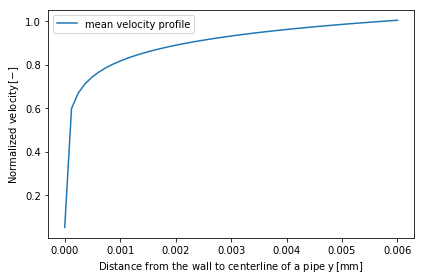

In [23]:
#mean velocity profile of a turbulent flow in a pipe at Re=, as a function of the distance.
plt.plot(y,u, label='mean velocity profile')
plt.legend()
plt.xlabel(r'Distance from the wall to centerline of a pipe y$\,\mathrm{[mm]}$')
plt.ylabel(r'Normalized velocity$\,\mathrm{[-]}$')

OutPutFig = './velocity_profile.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)

In [19]:
v_C2

1.4455930000000001